# Домашнее задание 3. VAE + NF + VAPNEV

### Загрузка данных
В данном задании вам предстоит снова работать с CelebA, но уже 64x64

Решением домашки является архив с использованными тетрадками/модулями, а так же .pdf файл с отчетом по проделанной работе по каждому пункту задачи. В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например, дополнительные лоссы для стабилизации, разные виды потоков, разные хаки для вае)



In [1]:
import fileinput
from math import log
from os.path import exists

import numpy as np
import requests
import torch
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.auto import trange

from homework_3.glow import Glow

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%capture

! pip install --upgrade --no-cache-dir gdown

In [2]:
url = "https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/utils/datasets/celeba.py"
if not exists("celeba.py"):
    with open("celeba.py", "wb") as f:
        f.write(requests.get(url).content)

for line in fileinput.input("celeba.py", inplace=True):
    if fileinput.filelineno() not in [45, 46]:
        print(line[:-1])
        continue
    if fileinput.filelineno() == 45:
        corrected_line = "                download_url = 'https://drive.google.com/file/d/17NNnHn1RyPPmb4iQqIGJ2XFulfwyW1Sh/view?usp=sharing'"
    else:
        corrected_line = "                gdown.download(download_url, download_path, quiet=False, fuzzy=True)"
    print(corrected_line)

url = "https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/data/celeba/list_attr_celeba.txt"
if not exists("list_attr_celeba.txt"):
    with open("list_attr_celeba.txt", "wb") as f:
        f.write(requests.get(url).content)

from celeba import CelebADataset

In [3]:
t_normalize = lambda x: x * 2 - 1
t_invnormalize = lambda x: (x + 1) / 2
transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        t_normalize,
    ]
)

Мы будем использовать урезанный датасет (`crop=True`) для быстрой загрузки на диск.

Для обучения модели вам нужно будет загрузить полную версию датасета.

Перед отправкой тетрадки в автопроверку ***ПРОВЕРЬТЕ*** что `crop=True`, иначе ваше решение будет таймаутиться

In [4]:
class CelebaCustomDataset(CelebADataset):
    def __getitem__(self, idx):
        image, target = super().__getitem__(idx)
        return image


dataset = CelebaCustomDataset(transform=transform, attr_file_path="list_attr_celeba.txt", crop=True)
img = dataset[0]
img.shape

torch.Size([3, 64, 64])

### Визуализация датасета

In [5]:
def plot_img(img, transform):
    plt.imshow(transform(img).permute(1, 2, 0))
    plt.axis("off")

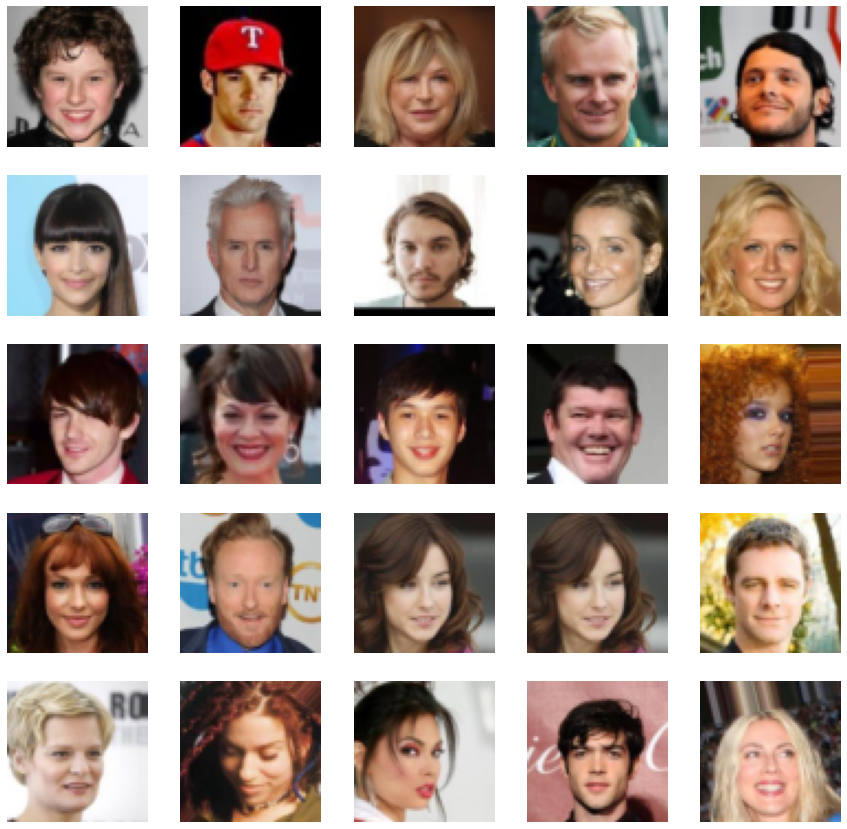

In [6]:
plt.figure(figsize=(15, 15))

for i in range(25):
    img = dataset[np.random.randint(len(dataset))]
    plt.subplot(5, 5, i + 1)
    plot_img(img, t_invnormalize)
plt.show()

In [7]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

### Задача 1 (4/10 балла). Построить и обучить нормпоток на CelebA 64x64

Здесь нужно обучить нормпоток до нормального (трешхолды будут позже) качества, померить FID и Negative Log Likelihood и запомнить для будущего сравнения

Внутри потока можно использовать все что вы хотите, Coupling/Autoregressive/Linear слои, любые трансформации и все что вам приходит в голову. Но все что вы используете - напишите сами, без копипаста.

Можно использовать как и сверточные потоки (будут лучше, но сложнее писать), так и линейные (будут хуже), развернув селебу в один вектор.

В принципе можно использовать тот код который уже есть в репозитории курса, но он довольно плохой и неэффективный) Лучше написать свой

In [9]:
def sample_moons(n: int):
    moons = make_moons(n_samples=n, noise=0.1)[0].astype(np.float32)
    return torch.from_numpy(moons)


def sample_mixture(n: int):
    assert n % 4 == 0
    r = np.r_[
        np.random.randn(n // 4, 2) * 0.5 + np.array([0, -2]),
        np.random.randn(n // 4, 2) * 0.5 + np.array([0, 0]),
        np.random.randn(n // 4, 2) * 0.5 + np.array([2, 2]),
        np.random.randn(n // 4, 2) * 0.5 + np.array([-2, 2]),
    ]
    return torch.from_numpy(r.astype(np.float32))

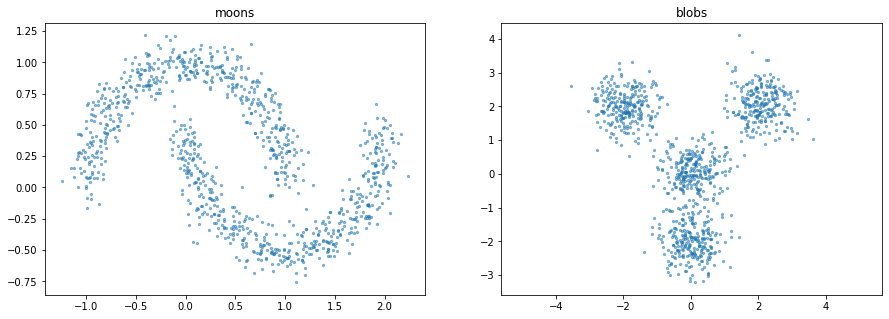

In [10]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("moons")
moons_sample = sample_moons(1000)
plt.scatter(moons_sample[:, 0], moons_sample[:, 1], s=5, alpha=0.5)
plt.subplot(1, 2, 2)
plt.title("blobs")
blobs_sample = sample_mixture(1000)
plt.scatter(blobs_sample[:, 0], blobs_sample[:, 1], s=5, alpha=0.5)
plt.axis("equal")
plt.show()

In [11]:
def plot_sample(model, sample_func):
    real = sample_func(1000)
    fake = model.sample(1000, 1, 2, device).detach().cpu()
    plt.scatter(real[:, 0], real[:, 1], label="real", c="blue", alpha=0.7, s=1)
    plt.scatter(fake[:, 0], fake[:, 1], label="fake", c="pink", alpha=0.5, s=1)
    plt.legend()
    plt.grid()

In [27]:
def train_synthetic(model, sample_func, n_steps: int = 10_000, lr: float = 0.001, batch_size: int = 128):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    model.train()

    with trange(n_steps, desc="Steps") as pbar:
        for _ in pbar:
            sample = sample_func(batch_size)

            log_p, log_det, _ = model(sample.to(device))

            log_det = log_det.mean()
            loss = log_p + log_det
            loss = -loss.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix({"loss": loss.item()})

Steps:   0%|          | 0/10000 [00:00<?, ?it/s]

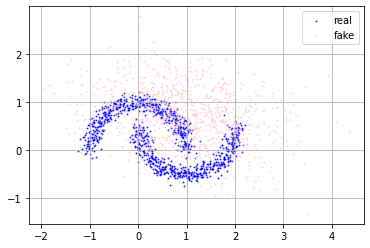

In [28]:
glow_moons = Glow(n_channels=1, n_filters=512, k_flow=3, l_block=1, is_linear=True).to(device)
train_synthetic(glow_moons, sample_moons)
glow_moons.eval()
plot_sample(glow_moons, sample_moons)

Steps:   0%|          | 0/10000 [00:00<?, ?it/s]

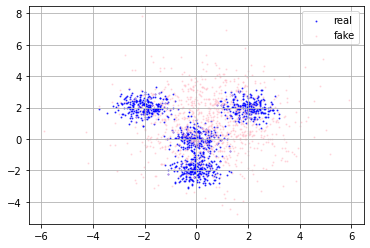

In [29]:
glow_mix = Glow(n_channels=1, n_filters=512, k_flow=3, l_block=1, is_linear=True).to(device)
train_synthetic(glow_mix, sample_mixture)
glow_mix.eval()
plot_sample(glow_mix, sample_mixture)

In [12]:
def calc_loss(log_p, log_det, n_bins, image_size):
    n_pixel = image_size * image_size * 3

    loss = -log(n_bins) * n_pixel
    loss = loss + log_det + log_p

    return (-loss / (log(2) * n_pixel)).mean()


def train_celeba(model, n_steps: int = 100, lr: float = 1e-3, batch_size: int = 128, n_bits: int = 5):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    model.train()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True).__iter__()
    n_bins = 2.0**n_bits

    with trange(n_steps, desc="Steps") as pbar:
        for _ in pbar:
            try:
                images = next(dataloader)
            except StopIteration:
                dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True).__iter__()
                images = next(dataloader)

            images = images.to(device) * 255

            if n_bits < 8:
                images = torch.floor(images / 2 ** (8 - n_bits))

            images = images / n_bins

            log_p, log_det, _ = model(images.to(device))
            log_det = log_det.mean()
            loss = calc_loss(log_p, log_det, n_bits, images.shape[-1])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix({"loss": loss.item()})

In [13]:
glow_celeba = Glow(n_channels=3, n_filters=512, k_flow=32, l_block=4).to(device)
train_celeba(glow_celeba)

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Задача 2 (2/10 балла). Построить и обучить VAE на CelebA 64x64

Здесь нужно обучить VAE до нормального (трешхолды будут позже) качества, померить FID и запомнить для будущего сравнения. 

В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой

Ради интереса, ваше вае тоже можно потестировать на маленьких датасетах


In [ ]:
# YOUR CODE HERE

### Задача 3 (6/10 балла). 

#### Задача 3.1 (4/10 балла) Построить и обучить VAPNEV на CelebA 64x64

Здесь нужно прочитать [статью про VAPNEV](https://arxiv.org/pdf/1611.05209.pdf), обучить его до нормального (трешхолды будут позже) качества, померить FID и запомнить для будущего сравнения. 

#### Задача 3.2 (2/10 балла). Построить и обучить conditional VAPNEV на CelebA 64x64

Вроде понятно из текста задачи. Что такое conditional VAPNEV, читайте в статье

In [ ]:
# YOUR CODE HERE

### Задача 4. (1/10 балла) Анализ

* Анализ латентного пространства и визуально качественный результат - **1 балл**
1. Посмотрите у какой модели получается лучшая интерполяция в латентном пространстве
2. Попробуйте взять внешнюю картинку (не из селебы), отмапить ее с латентное пространство и покажите ближайшие к ней.
3. Покажите самый смешной результат генерации который у вас получался

In [ ]:
# YOUR CODE HERE

### Задача 0. Отчет

Чтобы получить полный балл за каждый из пунктов вам нужно включить в отчет (который сдатеся отдельно в виде pdf) примеры (лучше - много примеров) генерации вашей модели. 

Сравните результаты разных моделей, попробуйте обьяснить почему одна сработала лучше чем другая.